In [ ]:
!pip install geopandas folium matplotlib shapely osmnx networkx pandas numpy ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.26.1 which is incompatible.
tensorflow-metadata 1.13.1 

In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import nearest_points
import networkx as nx
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
city_boundary = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/toronto-boundary/citygcs_regional_mun_wgs84.shp")
ttc_routes = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/ttc-shapefile/TTC_SUBWAY_LINES_WGS84.shp")
bus_routes = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/Toronto_TTC_Routes/Toronto_TTC_Routes.shp")
schools = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/School locations-all types data - 4326/School locations-all types data - 4326.shp")
mental_health_services = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/mental-health-locations/YOUTH_MENTALHEALTH_WGS84.shp")
neighborhoods_boundary = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/neighborhood_shapefile/NEIGHBORHOODS_WGS84_2.shp")

In [ ]:
# Convert .shp into visual stencils .crs
ttc_routes = ttc_routes.to_crs(city_boundary.crs)
mental_health_services = mental_health_services.to_crs(city_boundary.crs)
bus_routes = bus_routes.to_crs(city_boundary.crs)
neighborhoods = neighborhoods.to_crs(city_boundary.crs)


<ipython-input-24-68ed4d025b5b>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984  ...

  ttc_routes_clipped = gpd.clip(ttc_routes, city_boundary)
<ipython-input-24-68ed4d025b5b>:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984  ...

  bus_routes_clipped = gpd.clip(bus_routes, city_boundary)
<ipython-input-24-68ed4d025b5b>:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


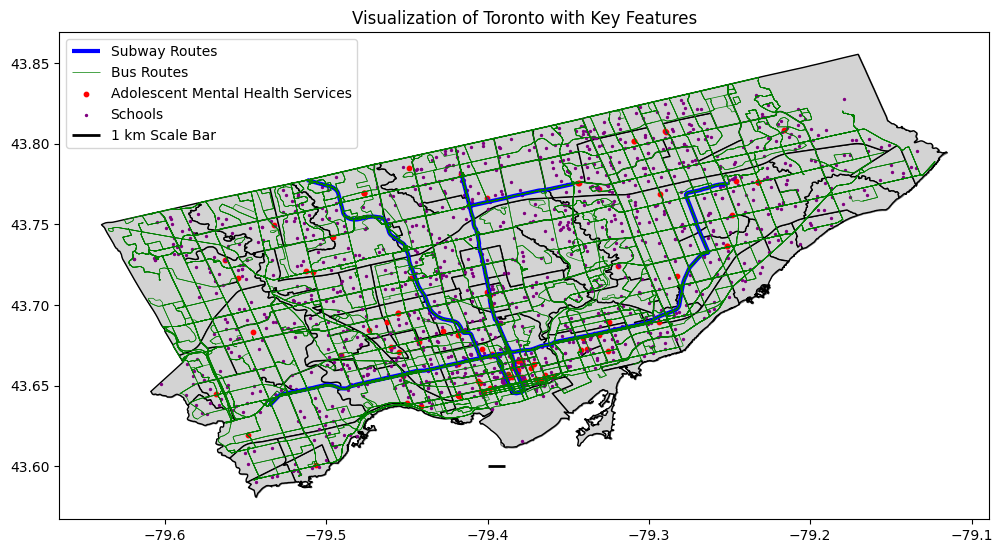

In [ ]:
# Clip to Toronto
ttc_routes_clipped = gpd.clip(ttc_routes, city_boundary)
bus_routes_clipped = gpd.clip(bus_routes, city_boundary)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
city_boundary.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5, label="City Boundary")
neighborhoods_boundary.plot(ax=ax, color="lightgray", edgecolor="black", alpha=1, label="City Boundary")
ttc_routes_clipped.plot(ax=ax, color="blue", linewidth=3, label="Subway Routes")
bus_routes_clipped.plot(ax=ax, color="green", linewidth=0.5, label="Bus Routes")
mental_health_services.plot(ax=ax, color="red", markersize=10, label="Adolescent Mental Health Services")
schools.plot(ax=ax, color="purple", markersize=2, label="Schools")

# Add scale bar
scale_bar = LineString([(-79.4, 43.6), (-79.389, 43.6)])  # Approx. 1 km
gpd.GeoSeries([scale_bar]).plot(ax=ax, color="black", linewidth=2, label="1 km Scale Bar")

# Add legend and title
plt.legend()
plt.title("Visualization of Toronto with Key Features")
plt.show()

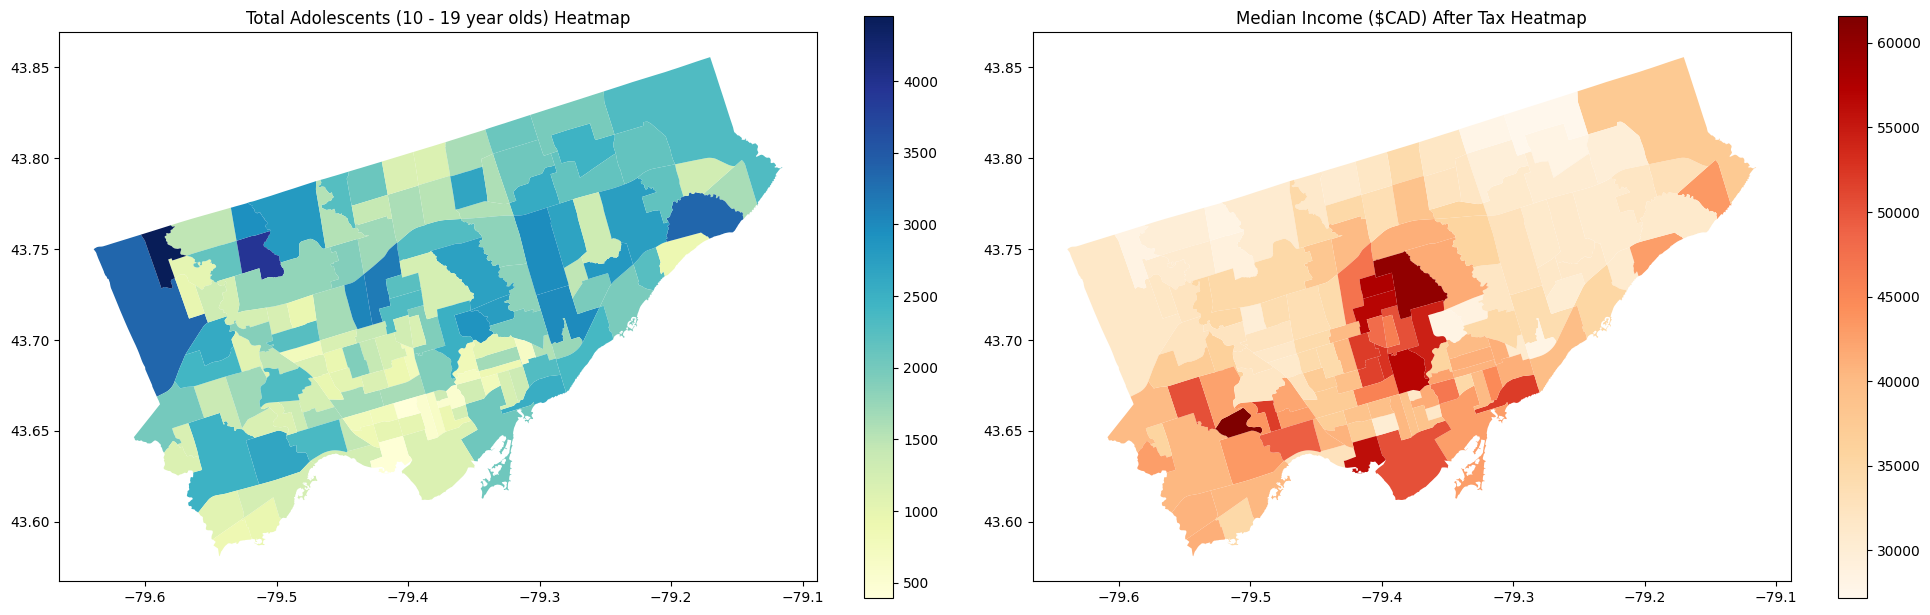

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Load the shapefile and Excel data
data = pd.read_excel("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/processed_neighborhoods_with_income_updated.xlsx")         # Replace with your Excel file path

# Step 2: Rename columns for clarity and process the data
data.columns = ['Neighborhood Name', 'Total Adolescents', 'Median Income After Tax',
                'Number', 'NEIGHBOUR_ID', 'Facility Count', 'Facilities per Population']

# Convert 'Number' in the Excel data to integers
data['Neighborhood Number'] = data['Number'].astype(int)

# Step 3: Merge the shapefile and Excel data
merged = neighborhoods.merge(
    data[['Neighborhood Number', 'Total Adolescents', 'Median Income After Tax',
          'Facility Count', 'Facilities per Population']],
    on='Neighborhood Number',  # Use 'Neighborhood Number' as the key
    how='left'
)
# Step 4: Plot the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Total Adolescents Heatmap
merged.plot(
    column='Total Adolescents',
    cmap='YlGnBu',
    legend=True,
    legend_kwds={'shrink': 0.6},
    ax=ax[0]
)
ax[0].set_title('Total Adolescents (10 - 19 year olds) Heatmap')

# Median Income After Tax Heatmap
merged.plot(
    column='Median Income After Tax',
    cmap='OrRd',
    legend=True,
    legend_kwds={'shrink': 0.6},
    ax=ax[1]
)
ax[1].set_title('Median Income ($CAD) After Tax Heatmap')

plt.tight_layout()
plt.show()


In [ ]:
neighborhoods.head()

,AREA_S_CD,AREA_NAME,geometry,Neighborhood Number
0,097,Yonge-St.Clair (97),"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",97
1,027,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",27
2,038,Lansing-Westgate (38),"POLYGON ((-79.43998 43.76156, -79.44004 43.761...",38
3,031,Yorkdale-Glen Park (31),"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",31
4,016,Stonegate-Queensway (16),"POLYGON ((-79.49262 43.64744, -79.49277 43.647...",16


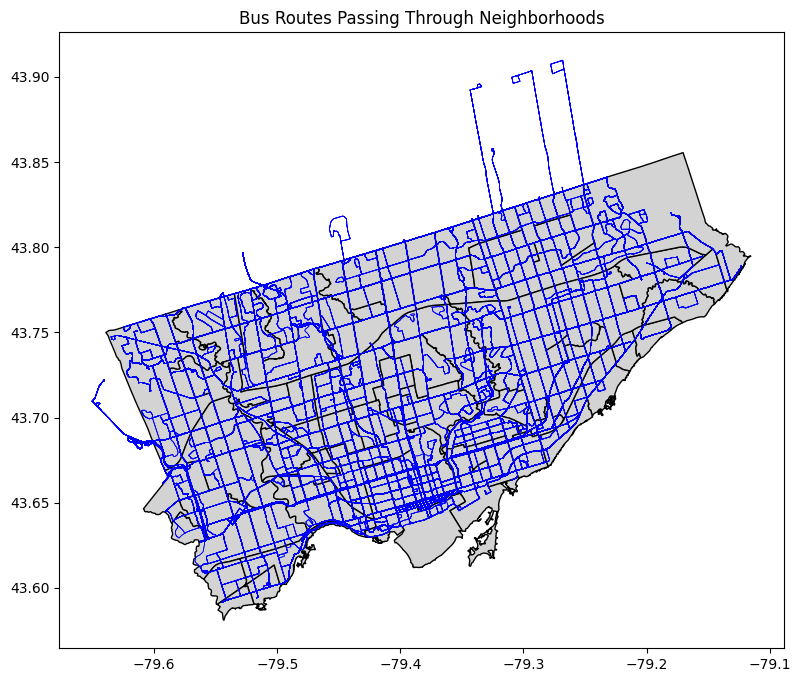

<ipython-input-26-c340006a2f4f>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  routes_in_neighborhoods.to_file("routes_in_neighborhoods.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Neighborhood Number' to 'Neighborho'
  ogr_write(


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Ensure CRS matches
bus_routes = bus_routes.to_crs(neighborhoods.crs)

# Spatial join: Find routes that intersect neighborhoods
routes_in_neighborhoods = gpd.sjoin(bus_routes, neighborhoods, how="inner", predicate="intersects")

# Reproject to a projected CRS
projected_routes = bus_routes.to_crs(epsg=32617)  # UTM Zone 17N for Toronto



# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
neighborhoods.plot(ax=ax, color="lightgrey", edgecolor="black")
routes_in_neighborhoods.plot(ax=ax, color="blue", linewidth=0.5)
plt.title("Bus Routes Passing Through Neighborhoods")
plt.show()

# Save results
routes_in_neighborhoods.to_file("routes_in_neighborhoods.shp")


In [ ]:
neighborhoods = neighborhoods.to_crs(epsg=3395)

In [ ]:
import geopandas as gpd
import pandas as pd

# Load the shapefile

# Load the routes data
routes_df = pd.read_excel("routes_per_neighborhood.xlsx")

# Merge the data on AREA_NAME
merged_df = neighborhoods.merge(routes_df, on="AREA_NAME", how="left")

# Calculate the area of each neighborhood in square kilometers (or square meters)
merged_df["area"] = merged_df.geometry.area / 1e6  # Convert from square meters to square kilometers if needed

# Calculate the route density (routes per square kilometer)
merged_df["route_density"] = merged_df["route_count"] / merged_df["area"]

# Print the route density for each neighborhood
print(merged_df[["AREA_NAME", "route_density"]])


                                    AREA_NAME  route_density
0                         Yonge-St.Clair (97)      62.763597
1                York University Heights (27)       7.422269
2                       Lansing-Westgate (38)      17.517372
3                     Yorkdale-Glen Park (31)      17.004875
4                    Stonegate-Queensway (16)      11.567992
5                Tam O'Shanter-Sullivan (118)       7.038110
6                            The Beaches (63)      11.381496
7            Thistletown-Beaumond Heights (3)       8.464076
8                       Thorncliffe Park (55)      12.905867
9                     Danforth East York (59)      38.572886
10                   Humewood-Cedarvale (106)      39.227257
11            Islington-City Centre West (14)       6.565982
12                              Danforth (66)      70.258819
13                                Rustic (28)      25.241793
14                  Scarborough Village (139)       7.476423
15                      